In [1]:
import pandas as pd
from tightening_project.data.loader import build_silver_auto

In [2]:
df_silver = pd.read_parquet(build_silver_auto())

required_cols = [
    "STEP_ID",
    "FinalTorque",
    "Torque_Result",
    "DateTime",
]

missing = [c for c in required_cols if c not in df_silver.columns]
if missing:
    raise KeyError(f"Faltan columnas en SILVER: {missing}")

# --- resumen por STEP_ID
step_summary = (
    df_silver
    .groupby("STEP_ID")
    .agg(
        n_total=("FinalTorque", "size"),
        n_nok=("Torque_Result", lambda x: (x == "NOK").sum()),
        first_ts=("DateTime", "min"),
        last_ts=("DateTime", "max"),
    )
    .reset_index()
)

step_summary["nok_rate"] = step_summary["n_nok"] / step_summary["n_total"]

# cobertura temporal en días (si timestamp es datetime)
step_summary["n_days_active"] = (
    (step_summary["last_ts"] - step_summary["first_ts"]).dt.days + 1
)

def classify_step(row):
    if row["n_total"] < 50:
        return "LOW_VOLUME"
    if row["n_days_active"] < 7:
        return "SHORT_LIVED"
    return "OK_FOR_SPC"

step_summary["step_status"] = step_summary.apply(classify_step, axis=1)
step_sumary = step_summary[step_summary["step_status"] == "OK_FOR_SPC"]
step_sumary


,STEP_ID,n_total,n_nok,first_ts,last_ts,nok_rate,n_days_active,step_status
0,112351201,2740,11,2026-01-07 06:40:23+00:00,2026-01-30 10:41:48+00:00,0.004015,24,OK_FOR_SPC
1,112351211,1630,6,2026-01-07 06:48:36+00:00,2026-01-30 10:53:12+00:00,0.003681,24,OK_FOR_SPC
2,112351221,704,2,2026-01-07 07:23:41+00:00,2026-01-30 11:11:15+00:00,0.002841,24,OK_FOR_SPC
3,112351231,58,0,2026-01-07 08:14:11+00:00,2026-01-30 08:48:33+00:00,0.000000,24,OK_FOR_SPC
4,112351301,64,0,2026-01-07 05:40:44+00:00,2026-01-28 09:05:00+00:00,0.000000,22,OK_FOR_SPC
...,...,...,...,...,...,...,...,...
174,811236721,126,1,2026-01-07 06:48:14+00:00,2026-01-30 08:01:36+00:00,0.007937,24,OK_FOR_SPC
176,811236741,124,0,2026-01-07 09:46:28+00:00,2026-01-29 09:05:44+00:00,0.000000,22,OK_FOR_SPC
177,811236751,600,4,2026-01-07 02:59:45+00:00,2026-01-29 10:34:37+00:00,0.006667,23,OK_FOR_SPC
178,811236761,328,1,2026-01-07 03:01:33+00:00,2026-01-30 08:58:23+00:00,0.003049,24,OK_FOR_SPC


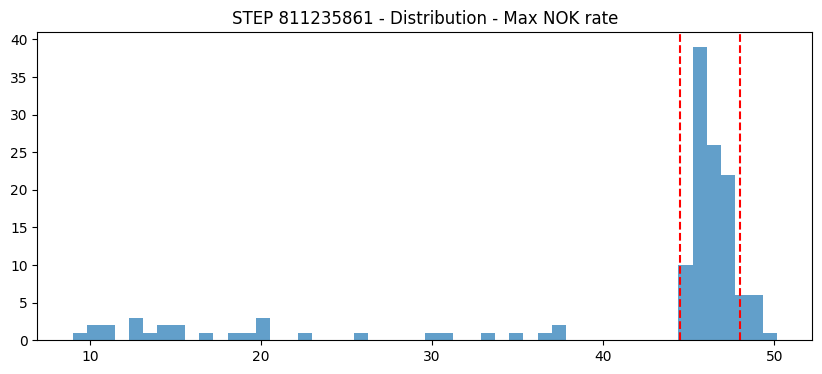

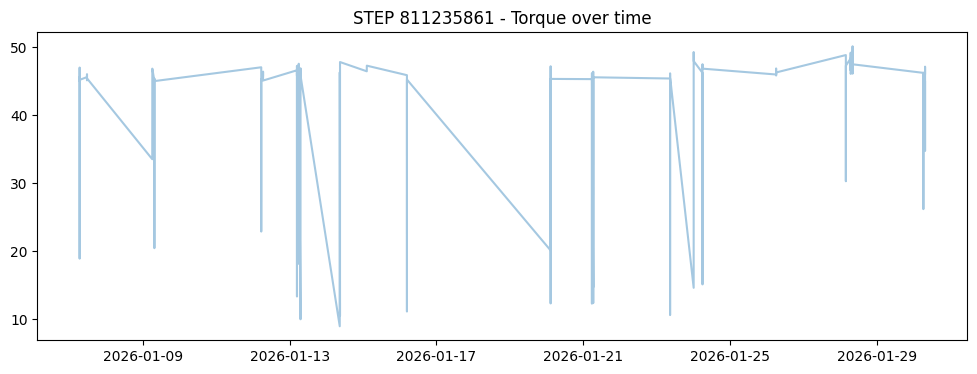

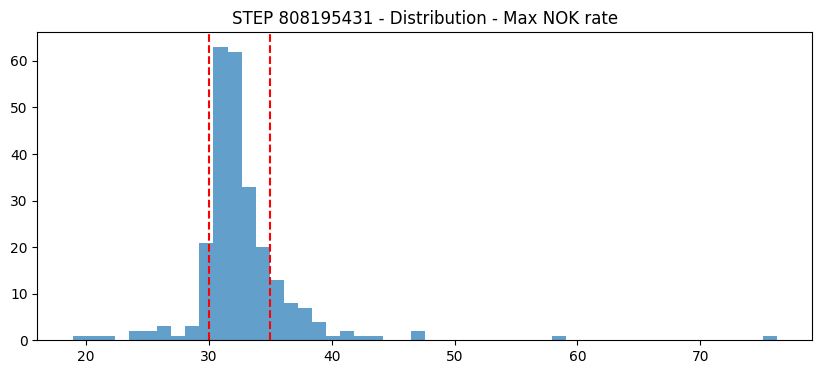

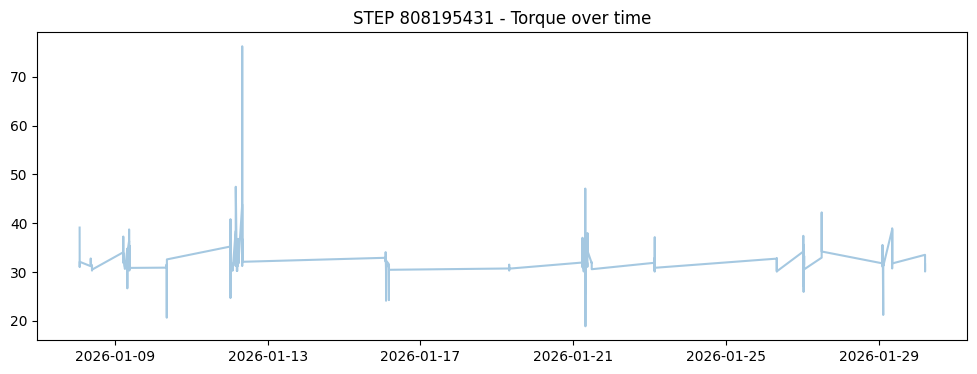

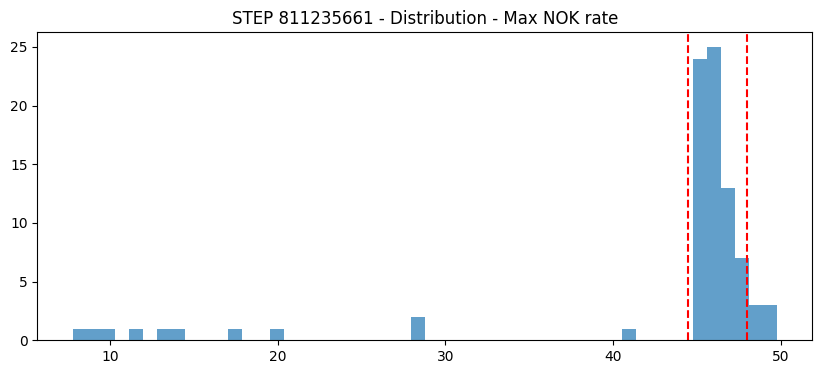

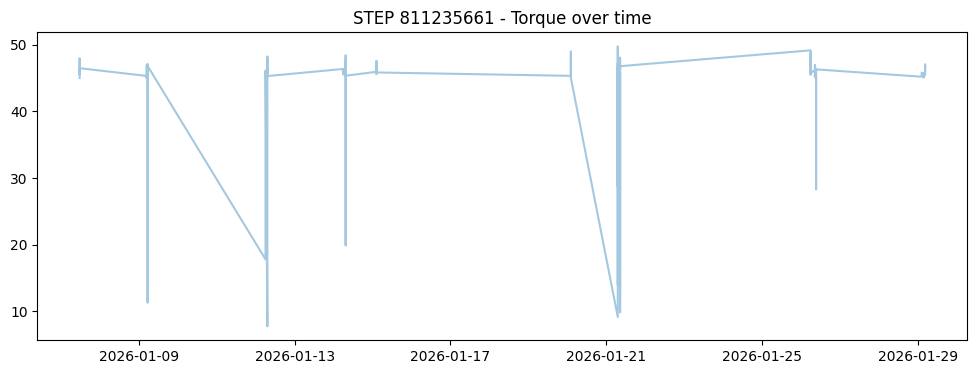

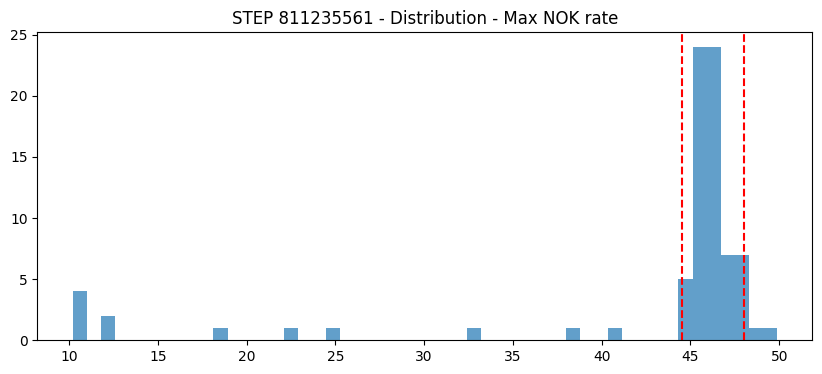

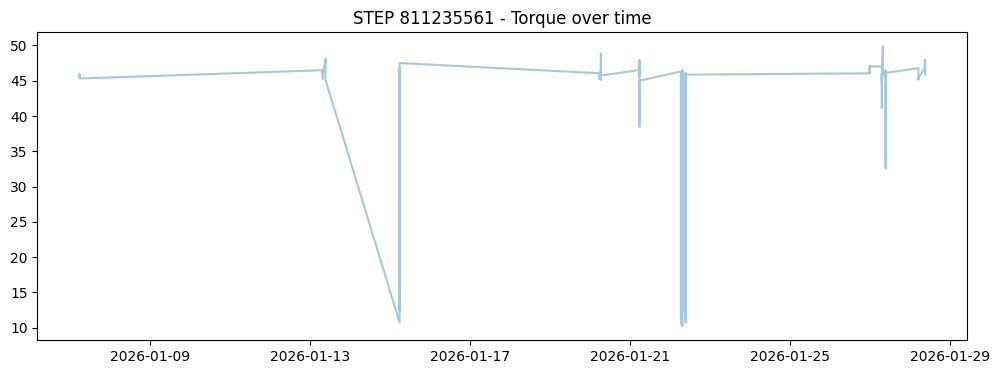

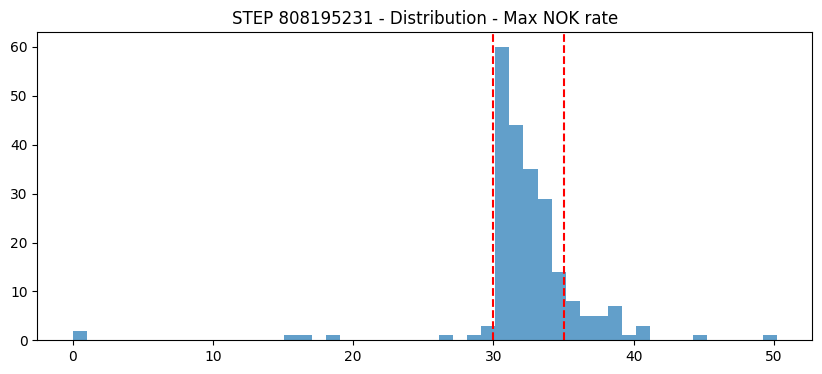

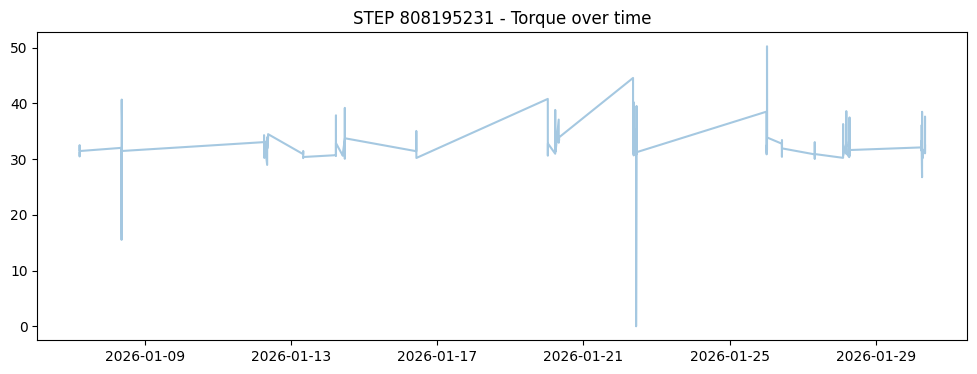

In [3]:
import matplotlib.pyplot as plt
step_id_max_rate_nok = (step_summary[step_summary["step_status"] == "OK_FOR_SPC"].sort_values("nok_rate", ascending=False).head(5)["STEP_ID"].tolist())

for step_id in step_id_max_rate_nok:
    df_step = df_silver[df_silver["STEP_ID"] == int(step_id)].sort_values("DateTime")
    # --- distribución
    plt.figure(figsize=(10,4))
    plt.hist(df_step["FinalTorque"], bins=50, alpha=0.7)
    plt.axvline(df_step["TorqueMinTolerance"].iloc[0], color="red", linestyle="--")
    plt.axvline(df_step["TorqueMaxTolerance"].iloc[0], color="red", linestyle="--")
    plt.title(f"STEP {step_id} - Distribution - Max NOK rate")
    plt.show()

# --- evolución temporal
    plt.figure(figsize=(12,4))
    plt.plot(df_step["DateTime"], df_step["FinalTorque"], alpha=0.4)
    plt.title(f"STEP {step_id} - Torque over time")
    plt.show()


#### Notaciones para 5 STEPs con mayor cantidad de max rate nok

##### STEP 811235861
Histograma
- Unimodal, concentrada alrededor de 45–48
- Muchísimos valores fuera de especificación por debajo del LSL (≈10–30)
- Parte central cumple, pero la cola izquierda es muy fuerte

Serie temporal
- Nivel base estable cerca de 45–47
- Caídas abruptas y repetidas (hasta ~10–20)
- No hay drift lento, hay saltos violentos

Diagnóstico
- Inestable
- No capaz (violaciones severas del LSL)
- Setpoint correcto, pero proceso no confiable
- Saltos frecuentes
- Drift: NO

Clasificación
- Inestable / mezcla / saltos
- Riesgo: Muy alto

El proceso presenta una distribución unimodal con la mayor concentración de valores dentro del rango nominal, alrededor de 45–48. Sin embargo, se observa una cantidad significativa de valores muy por debajo del LSL, lo que indica eventos severos fuera de especificación. El análisis temporal muestra un comportamiento base estable, interrumpido por caídas abruptas y repetidas de gran magnitud, sin evidencia de drift lento. Estos eventos corresponden a causas especiales que afectan directamente la capacidad del proceso. A pesar de un setpoint aparentemente correcto, el proceso es inestable y no confiable bajo las condiciones actuales.
Características clave: saltos severos, OOS por debajo del LSL, sin drift, centrado nominal aceptable pero riesgo operativo muy alto.

##### STEP 808195431
Histograma
- Unimodal con pico alrededor de 30–33
- Sesgo a la derecha
- Valores por encima del USL (cola larga hasta ~75)
- Algunos valores bajos cercanos al LSL

Serie temporal
- Nivel base relativamente estable (~30–33)
- Picos muy altos esporádicos
- Alguna caída aislada
- Sin drift lento

Diagnóstico
- Inestable por causas especiales
- No capaz (USL violado repetidamente)
- Centrado aceptable, pero margen insuficiente
- Saltos (picos)

Clasificación:
- Inestable / mezcla / saltos
- Riesgo: Alto–Muy alto

El proceso muestra una distribución unimodal con sesgo a la derecha, concentrada principalmente alrededor de 30–33. Se observa una cola larga con múltiples valores por encima del USL, así como algunos valores cercanos al LSL. El comportamiento temporal es mayormente estable en nivel, pero interrumpido por picos altos esporádicos que generan violaciones de especificación. No se observa drift lento, sino eventos puntuales de causa especial. El proceso no es capaz debido a las violaciones recurrentes del USL y presenta un nivel de inestabilidad que lo hace poco predecible.
Características clave: picos altos, violaciones del USL, sesgo positivo, sin drift, riesgo alto.

##### STEP 811235661
Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL
- Algunos outliers bajos y altos, pocos

Serie temporal
- Nivel estable ~45–47
- Caídas aisladas y picos aislados
- No drift, no cambio de nivel

Diagnóstico
- Estable en operación normal
- Bien centrado
- OOS puntuales por causa especial
- Drift: NO
- Saltos estructurales: NO

Clasificación
- Estable y centrado
Riesgo: Bajo

El proceso presenta una distribución unimodal, estrecha y aproximadamente simétrica, correctamente centrada dentro de los límites de especificación. El análisis temporal muestra un comportamiento estable durante la mayor parte del período, con baja variabilidad y sin evidencia de drift lento o cambios de nivel. Existen valores fuera de especificación puntuales, tanto por debajo del LSL como por encima del USL, que corresponden a eventos aislados de causa especial y no representan el comportamiento normal del proceso. En condiciones normales, el proceso es estable, capaz y adecuadamente ajustado.
Características clave: estabilidad, buen centrado, OOS aislados, sin drift, bajo riesgo operativo.

##### STEP 811235561
Distribución
- Unimodal, bien concentrada cerca de 45–48
- Valores fuera de especificación por debajo del LSL
- Algunos valores altos cercanos al USL

Serie temporal
- Nivel base estable
- Caídas muy profundas y repetidas (~10–12)
- Eventos severos, no ruido

Diagnóstico
- Inestable
- No capaz (LSL violado)
- Centrado nominal correcto
- Saltos severos
- Drift: NO

Clasificación
- Inestable / mezcla / saltos
- Riesgo: Muy alto

El proceso muestra una distribución unimodal bien concentrada en el rango nominal, pero con múltiples valores fuera de especificación por debajo del LSL. El comportamiento temporal revela un proceso estable en nivel durante la operación normal, interrumpido por caídas abruptas y profundas que se repiten a lo largo del período analizado. No se observa drift lento; el problema está dominado por eventos de causa especial severos. A pesar de un centrado nominal aceptable, la recurrencia y magnitud de estos eventos hacen que el proceso sea inestable y no capaz.


Características clave: caídas severas, OOS por debajo del LSL, sin drift, alto riesgo operativo.

##### STEP 808195231 (reconfirmación)
Histograma

- Unimodal, sesgada a la derecha
- Alta concentración cerca del LSL
- Valores por debajo del LSL y por encima del USL

Serie temporal
- Nivel base cercano al LSL
- Caídas extremas (~0)
- Picos altos (~50)
- Saltos frecuentes

Diagnóstico
- Inestable
- No capaz
- Centrado altamente riesgoso
- Saltos severos
- Drift: NO

Clasificación
- Inestable / mezcla / saltos
- Riesgo: Muy alto

El proceso presenta una distribución unimodal claramente sesgada a la derecha, con una alta concentración de datos muy próximos al LSL, lo que evidencia un centrado altamente riesgoso. Se observan valores fuera de especificación tanto por debajo del LSL como por encima del USL. El análisis temporal muestra un proceso dominado por saltos abruptos, con caídas extremas y picos elevados, sin presencia de drift lento. La combinación de centrado inadecuado, falta de estabilidad y múltiples violaciones de especificación clasifica al proceso como inestable y no capaz, con un riesgo operativo muy elevado.
Características clave: centrado riesgoso, saltos severos, OOS en ambos extremos, sin drift.




#### Analisis 5 step_id con mayor cantidad de operaciones

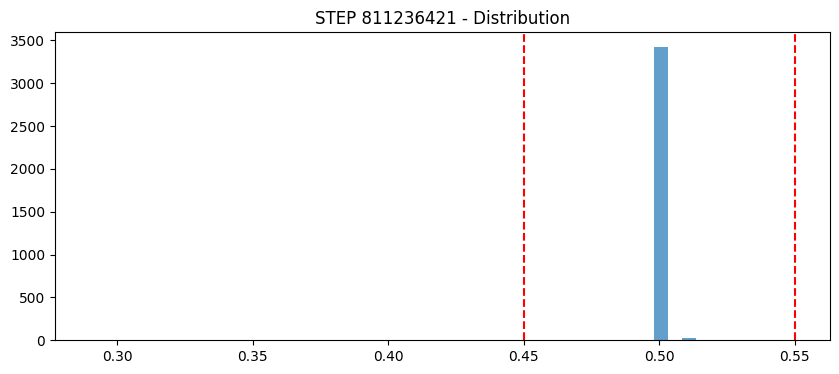

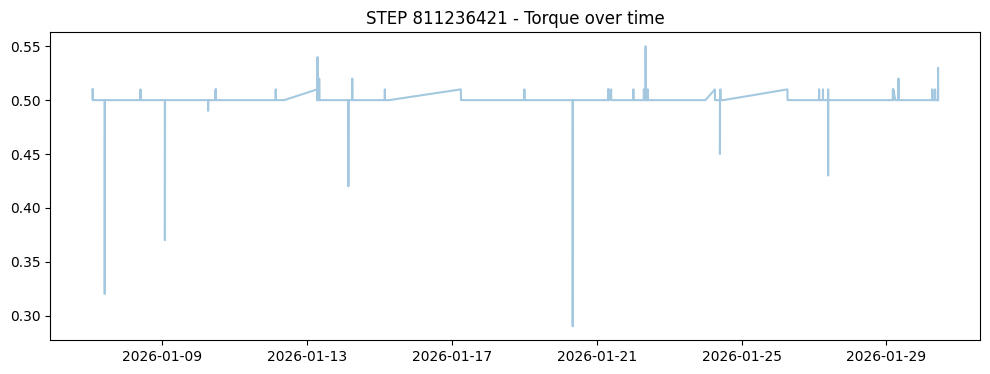

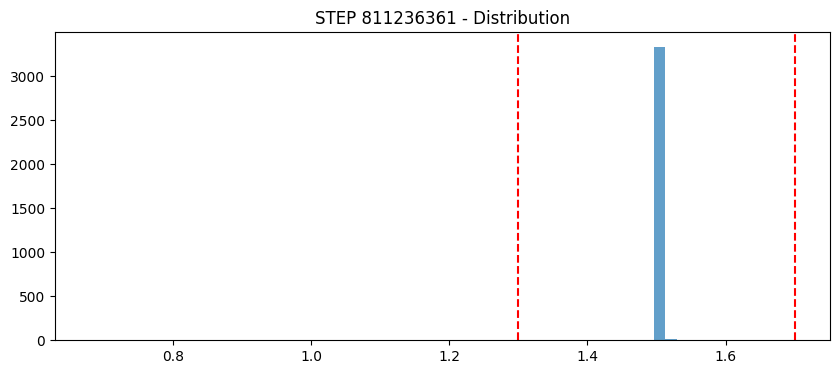

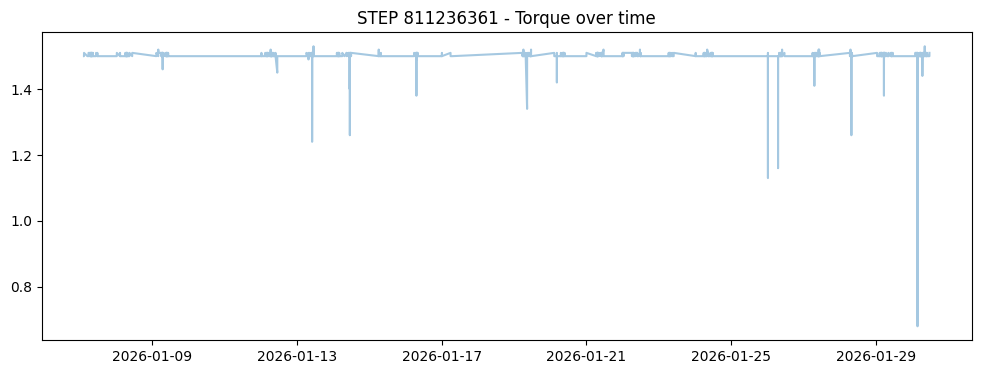

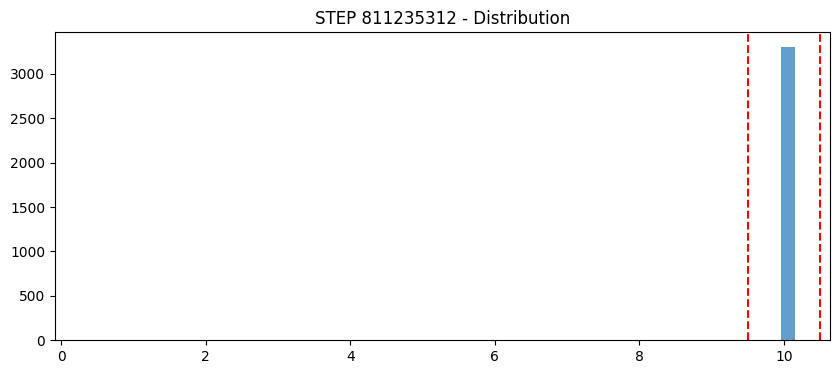

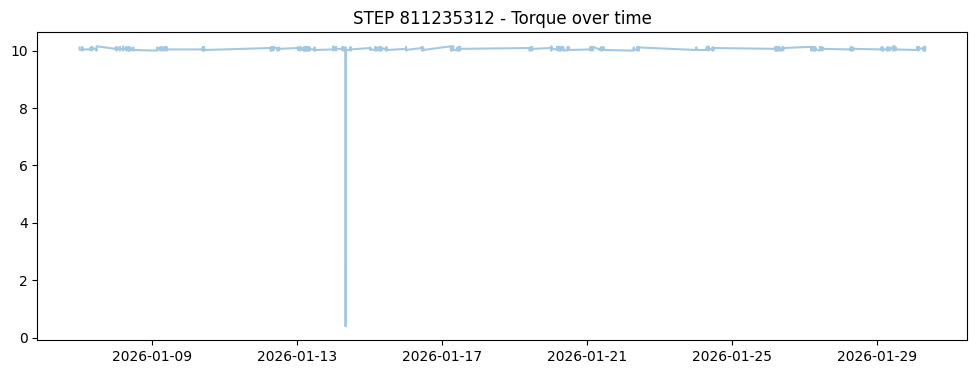

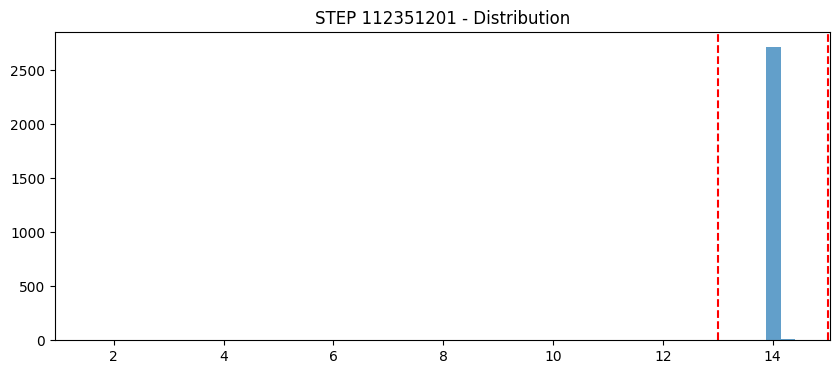

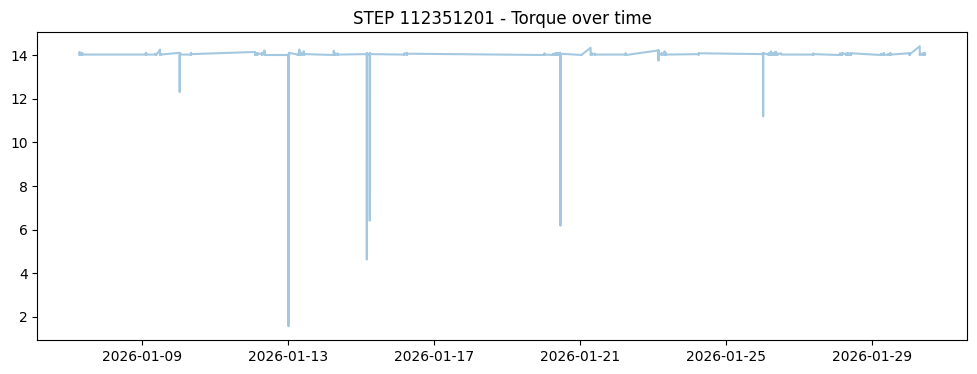

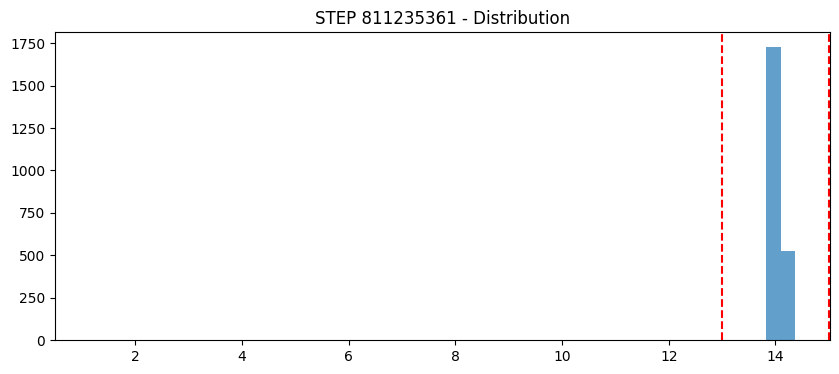

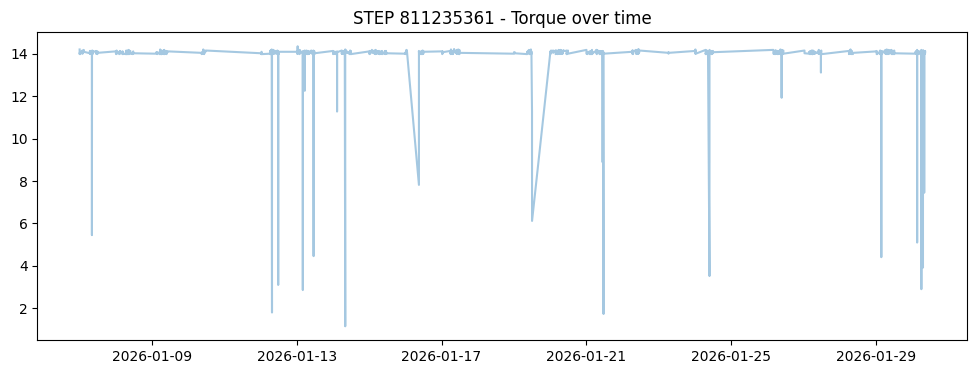

In [4]:
step_id_max_n_total = (step_summary[step_summary["step_status"] == "OK_FOR_SPC"].sort_values("n_total", ascending=False).head(5)["STEP_ID"].tolist())

for step_id in step_id_max_n_total:
    df_step = df_silver[df_silver["STEP_ID"] == int(step_id)].sort_values("DateTime")
    # --- distribución
    plt.figure(figsize=(10,4))
    plt.hist(df_step["FinalTorque"], bins=50, alpha=0.7)
    plt.axvline(df_step["TorqueMinTolerance"].iloc[0], color="red", linestyle="--")
    plt.axvline(df_step["TorqueMaxTolerance"].iloc[0], color="red", linestyle="--")
    plt.title(f"STEP {step_id} - Distribution")
    plt.show()

# --- evolución temporal
    plt.figure(figsize=(12,4))
    plt.plot(df_step["DateTime"], df_step["FinalTorque"], alpha=0.4)
    plt.title(f"STEP {step_id} - Torque over time")
    plt.show()

#### Notaciones para 5 STEPs con mayor cantidad de veces realizados

##### STEP 811236421
Resumen descriptivo:
El proceso presenta una distribución extremadamente concentrada y unimodal alrededor del valor nominal (~0.50), claramente dentro de los límites de especificación definidos por LSL y USL. La dispersión es mínima, lo que indica muy baja variabilidad en operación normal.
En la serie temporal, el nivel se mantiene estable alrededor del setpoint, sin drift progresivo. Se observan algunas caídas puntuales por debajo del LSL, aisladas en el tiempo, que corresponden a eventos de causa especial y no alteran el comportamiento general del proceso.

Distribución
-Unimodal, muy estrecha, fuertemente concentrada dentro de LSL/USL  
-Outliers bajos muy puntuales

Serie temporal
- Nivel estable ~0.50  
- Caídas aisladas por debajo del LSL  
- Sin drift ni cambio de nivel

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- OOS puntuales por causa especial  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 811236361
Resumen descriptivo
La distribución es unimodal y muy estrecha, con el grueso de los datos centrados alrededor de ~1.50 y bien contenidos entre LSL y USL. La variabilidad normal es muy baja.
El comportamiento temporal muestra un proceso estable, sin drift lento, aunque aparecen caídas aisladas y profundas que generan violaciones puntuales del LSL. Estos eventos son claramente excepcionales y no representan el comportamiento típico del proceso.

Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL  
- Outliers bajos aislados

Serie temporal
- Nivel estable ~1.50  
- Caídas aisladas profundas  
- Sin drift ni tendencia

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- OOS puntuales por debajo del LSL  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 811235312
Resumen descriptivo
El proceso muestra una distribución unimodal extremadamente concentrada alrededor de ~10, perfectamente ubicada dentro de los límites de especificación. La dispersión es mínima.
En la serie temporal, el torque se mantiene estable y sin variaciones relevantes, salvo una caída única y muy marcada que cruza el LSL. Este evento es claramente aislado y no afecta la estabilidad general del proceso.

Distribución
- Unimodal, muy estrecha, centrada dentro de LSL/USL  
- Un outlier bajo aislado

Serie temporal
- Nivel muy estable ~10  
- Una caída extrema puntual  
- Sin drift ni cambio de nivel

Diagnóstico
- Estable en operación normal  
- Muy bien centrado  
- OOS puntual por causa especial  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 112351201
Resumen descriptivo
La distribución es unimodal y altamente concentrada alrededor de ~14, completamente dentro de LSL y USL. No se observa ensanchamiento ni sesgo relevante.
La serie temporal muestra un nivel estable sin drift, aunque con varias caídas puntuales que cruzan el LSL. Estas caídas son eventos de causa especial bien definidos y no afectan el centrado ni la estabilidad estructural del proceso.

Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL  
- Outliers bajos aislados

Serie temporal
- Nivel estable ~14  
- Varias caídas puntuales por debajo del LSL  
- Sin drift

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- OOS puntuales por causa especial  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 811235361
Resumen descriptivo
El proceso presenta una distribución unimodal estrecha y correctamente centrada alrededor de ~14, completamente dentro de los límites de especificación.
El análisis temporal indica un proceso estable en nivel, pero con numerosas caídas puntuales y repetidas que cruzan el LSL, algunas de ellas de gran magnitud. Aunque el proceso base es estable y bien centrado, la frecuencia de estos eventos aumenta el riesgo operativo respecto a otros STEPs verdes.

Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL  
- Outliers bajos recurrentes

Serie temporal
- Nivel estable ~14  
- Caídas repetidas por debajo del LSL  
- Sin drift lento

Diagnóstico
- Estable en nivel  
- Bien centrado  
- OOS recurrentes por causa especial  
- Drift: NO  
- Saltos puntuales frecuentes  

Clasificación
- Estable y centrado  
- Riesgo: Medio


#### Notaciones para 5 STEPs con menor ratio de NOK

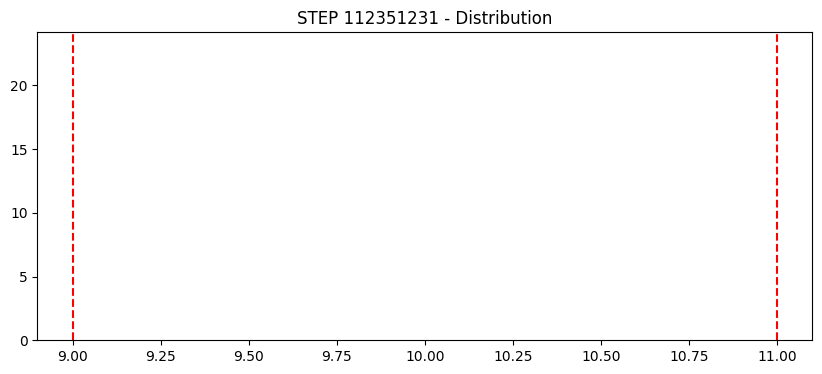

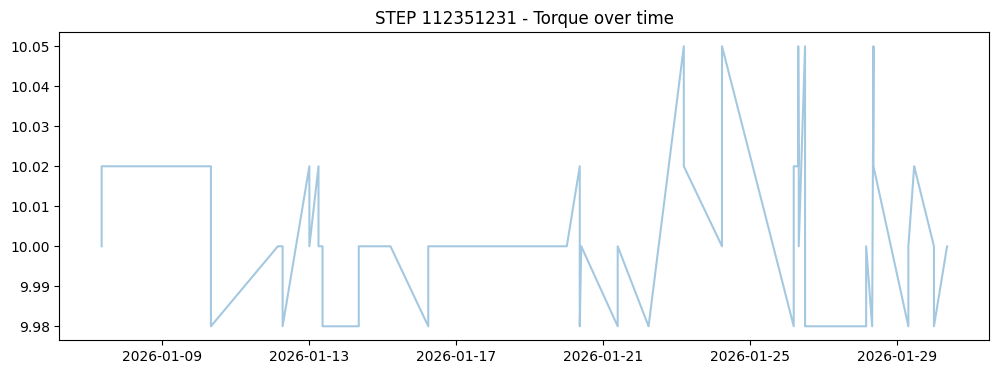

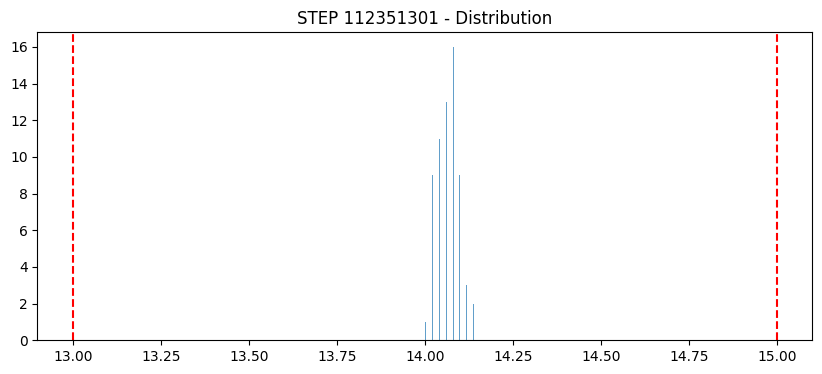

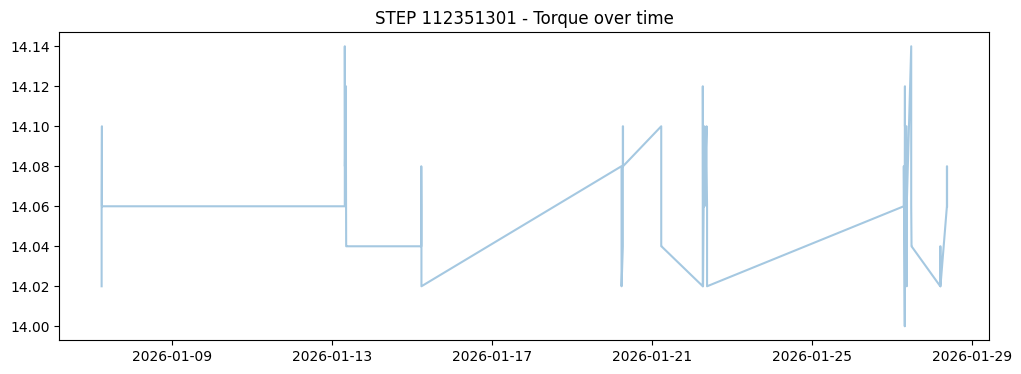

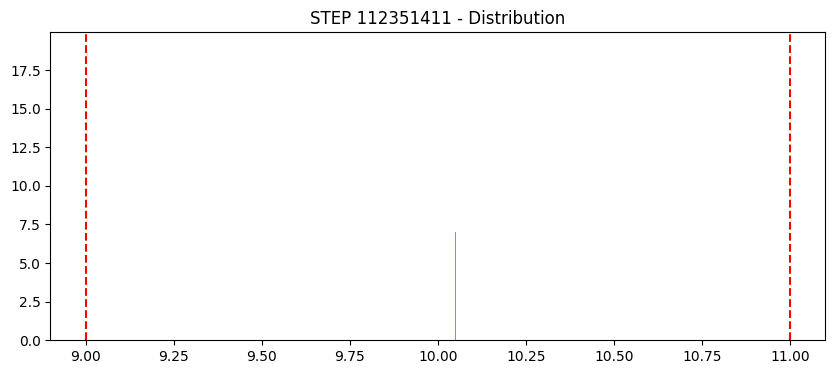

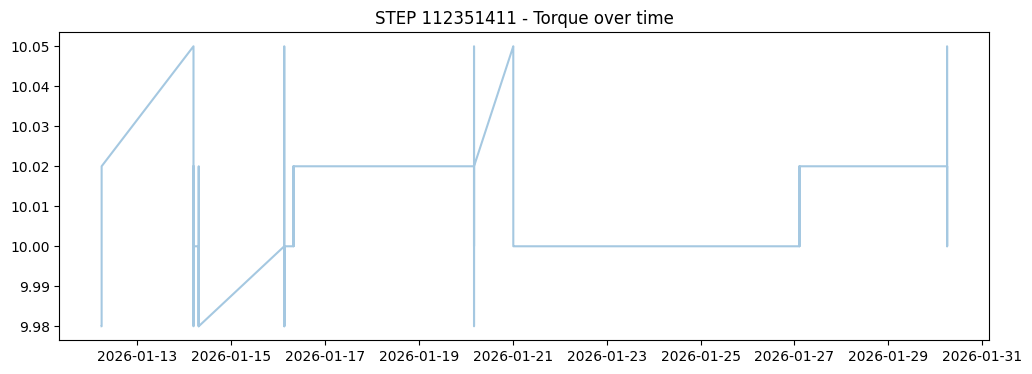

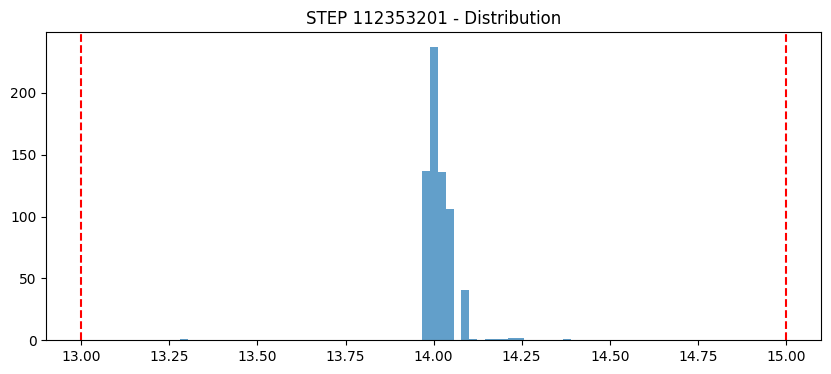

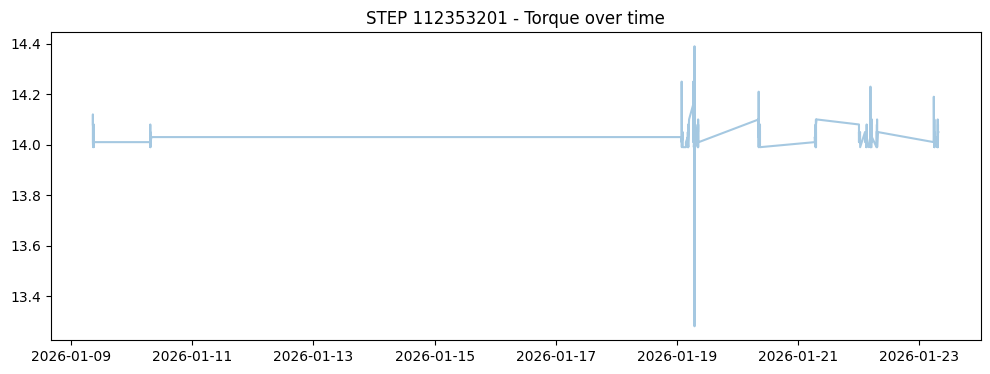

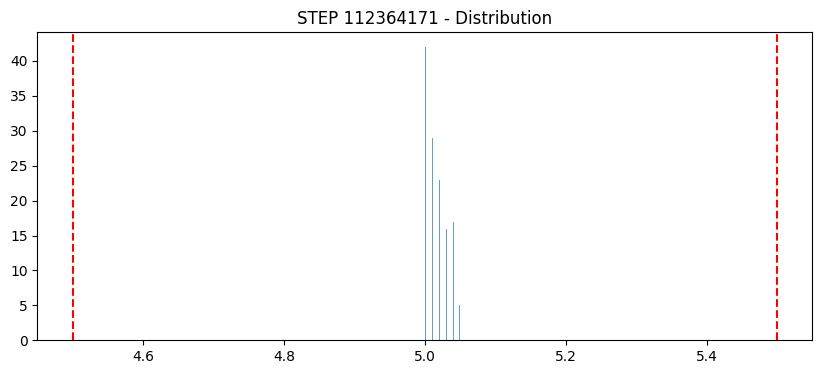

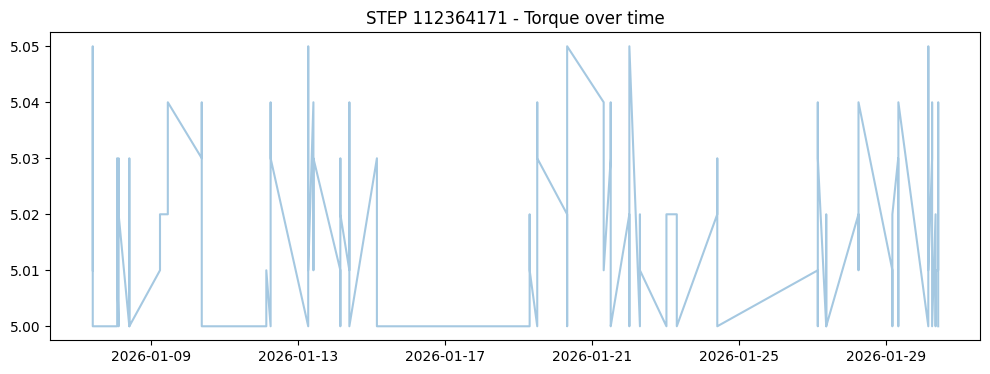

In [5]:
step_id_min_rate_nok = (step_summary[step_summary["step_status"] == "OK_FOR_SPC"].sort_values("nok_rate", ascending=True).head(5)["STEP_ID"].tolist())

for step_id in step_id_min_rate_nok:
    df_step = df_silver[df_silver["STEP_ID"] == int(step_id)].sort_values("DateTime")
    # --- distribución
    plt.figure(figsize=(10,4))
    plt.hist(df_step["FinalTorque"], bins=50, alpha=0.7)
    plt.axvline(df_step["TorqueMinTolerance"].iloc[0], color="red", linestyle="--")
    plt.axvline(df_step["TorqueMaxTolerance"].iloc[0], color="red", linestyle="--")
    plt.title(f"STEP {step_id} - Distribution")
    plt.show()

# --- evolución temporal
    plt.figure(figsize=(12,4))
    plt.plot(df_step["DateTime"], df_step["FinalTorque"], alpha=0.4)
    plt.title(f"STEP {step_id} - Torque over time")
    plt.show()

#### Notaciones para 5 STEPs con menor ratio de NOK

##### STEP 112351231
Resumen descriptivo
El proceso presenta una distribución extremadamente estrecha y concentrada alrededor de 10, completamente contenida entre el LSL y el USL. No se observan colas ni dispersión relevante.
La serie temporal muestra un nivel muy estable con pequeñas oscilaciones alrededor del setpoint y sin eventos fuera de especificación. No hay evidencia de drift lento ni de saltos abruptos. El proceso es altamente repetible y bien ajustado.

Distribución
- Unimodal, extremadamente estrecha, bien centrada entre LSL/USL  
- Sin outliers relevantes

Serie temporal
- Nivel muy estable ~10  
- Pequeñas oscilaciones normales  
- Sin caídas ni picos OOS

Diagnóstico
- Estable en operación normal  
- Muy bien centrado  
- Sin OOS  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación:
- Estable y centrado  
- Riesgo: Bajo

##### STEP 112351301
Resumen descriptivo
La distribución es unimodal y muy concentrada alrededor de 14, ubicada cómodamente entre los límites de especificación. La variabilidad es baja y no se aprecian colas largas.
En el tiempo, el proceso mantiene un nivel estable, con ligeras oscilaciones y algunos picos aislados que permanecen dentro de especificación. No se detecta drift progresivo ni cambios de nivel.

Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL  
- Sin outliers significativos

Serie temporal
- Nivel estable ~14  
- Oscilaciones menores dentro de especificación  
- Sin drift ni saltos

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- Capaz  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 112351411
Resumen descriptivo
El proceso muestra una distribución extremadamente concentrada alrededor de 10, completamente dentro de los límites de especificación. La dispersión es mínima.
La serie temporal indica estabilidad general del nivel, con algunos pequeños cambios escalonados y oscilaciones suaves, pero sin violaciones de LSL ni USL. No se observa drift lento ni eventos severos.

Distribución
- Unimodal, muy estrecha, centrada dentro de LSL/USL  
- Sin outliers

Serie temporal
- Nivel estable ~10  
- Pequeños escalones normales  
- Sin OOS ni drift

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- Sin OOS  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 112353201
Resumen descriptivo
La distribución es unimodal y estrecha, centrada alrededor de 14, bien contenida entre los límites de especificación. Existe una ligera dispersión mayor que en otros STEPs, pero sin comprometer el centrado.
En el gráfico temporal se observa un proceso estable, con una caída puntual por debajo del LSL claramente identificable como evento aislado de causa especial. El comportamiento normal permanece estable y repetible.

Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL  
- Un outlier bajo aislado

Serie temporal
- Nivel estable ~14  
- Una caída puntual por debajo del LSL  
- Sin drift progresivo

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- OOS puntual por causa especial  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 112364171
Resumen descriptivo
El proceso presenta una distribución unimodal muy concentrada alrededor de 5, claramente dentro de los límites de especificación. La variabilidad es baja y no se observan colas.
La serie temporal muestra oscilaciones frecuentes pero de baja magnitud alrededor del setpoint, sin eventos que crucen los límites de especificación. No hay drift ni cambios estructurales en el comportamiento.

Distribución
- Unimodal, estrecha, bien centrada entre LSL/USL  
- Sin outliers relevantes

Serie temporal
- Nivel estable ~5  
- Oscilaciones frecuentes pero pequeñas  
- Sin OOS ni drift

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- Capaz  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

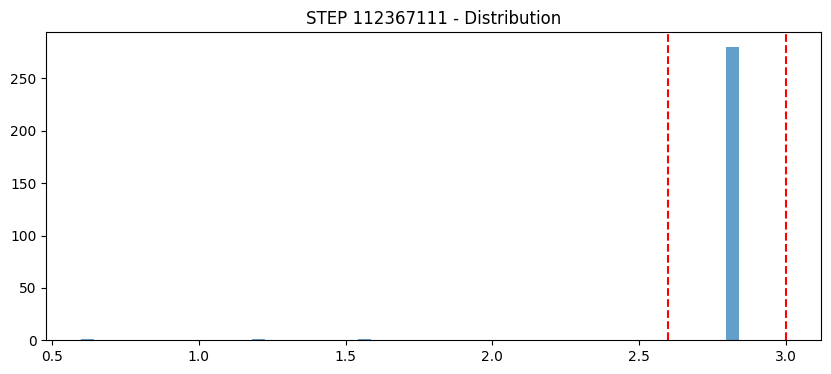

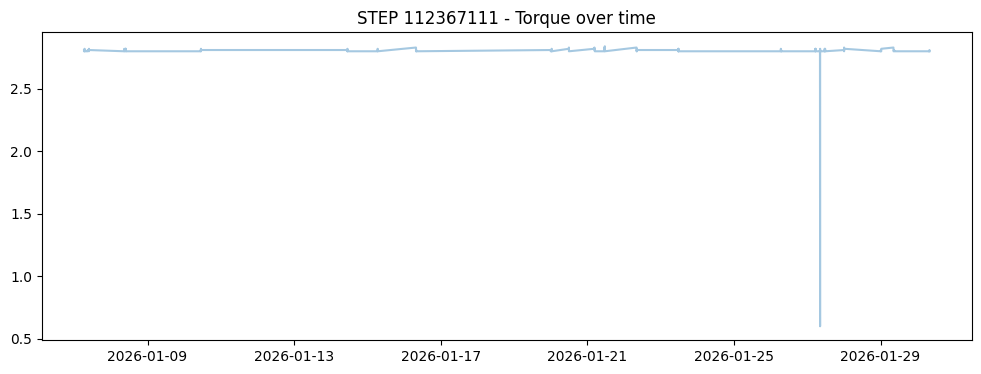

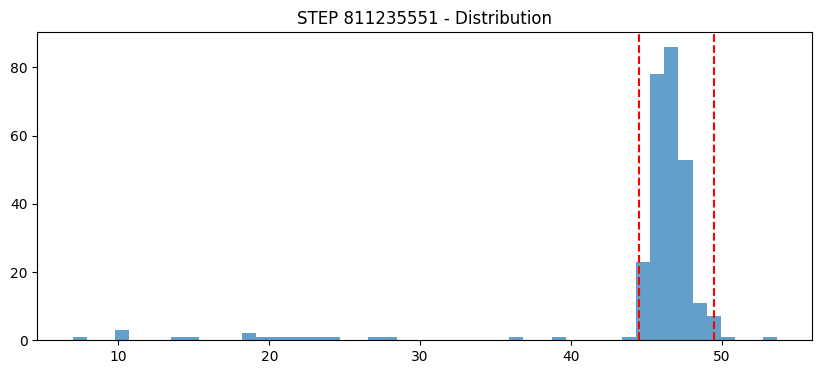

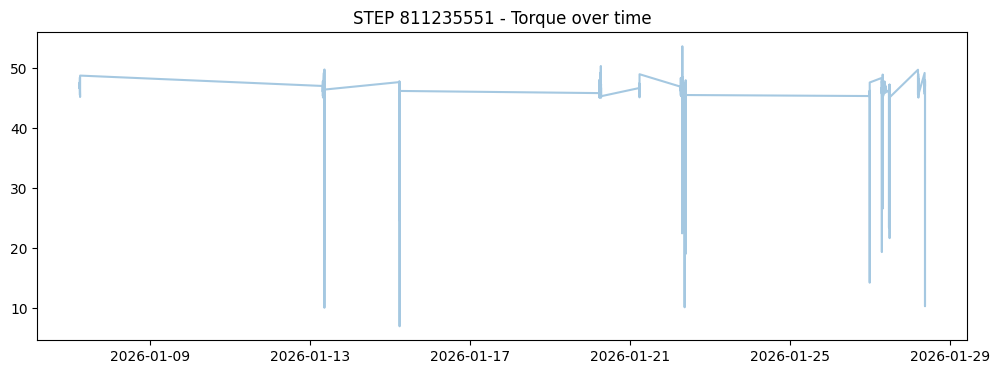

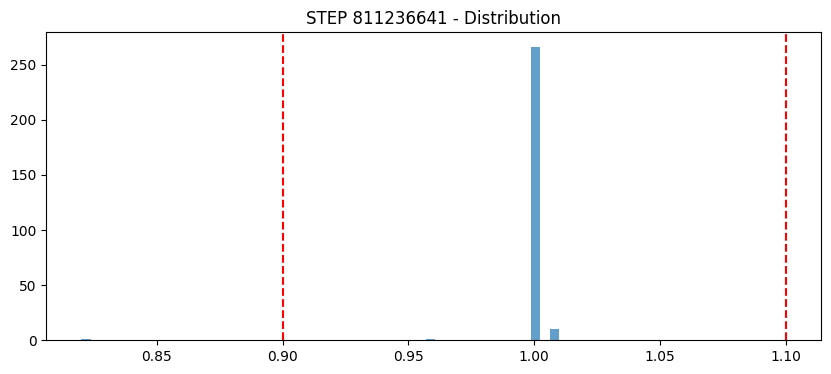

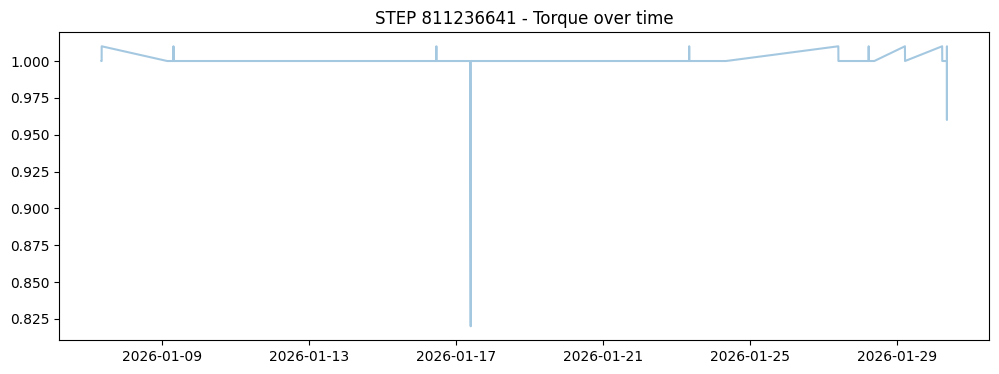

In [6]:
df = (step_summary[step_summary["step_status"] == "OK_FOR_SPC"].sort_values("n_total", ascending=False).reset_index(drop=True))

median_idx = len(df) // 2
median_list = df.loc[[median_idx - 1, median_idx, median_idx + 1],"STEP_ID"].tolist()

for step_id in median_list:
    df_step = df_silver[df_silver["STEP_ID"] == int(step_id)].sort_values("DateTime")
    # --- distribución
    plt.figure(figsize=(10,4))
    plt.hist(df_step["FinalTorque"], bins=50, alpha=0.7)
    plt.axvline(df_step["TorqueMinTolerance"].iloc[0], color="red", linestyle="--")
    plt.axvline(df_step["TorqueMaxTolerance"].iloc[0], color="red", linestyle="--")
    plt.title(f"STEP {step_id} - Distribution")
    plt.show()

# --- evolución temporal
    plt.figure(figsize=(12,4))
    plt.plot(df_step["DateTime"], df_step["FinalTorque"], alpha=0.4)
    plt.title(f"STEP {step_id} - Torque over time")
    plt.show()

#### Notaciones para la mediana y +-1 respecto a la mediana

##### STEP 112367111
Resumen descriptivo
El proceso presenta una distribución extremadamente concentrada y unimodal alrededor de ~2.8, claramente ubicada dentro de los límites de especificación definidos por LSL y USL. La dispersión es mínima y no se observan colas relevantes.
En la serie temporal, el nivel se mantiene muy estable durante casi todo el período, sin drift progresivo ni cambios de nivel. Se observa una caída única y muy severa que cruza ampliamente el LSL, claramente identificable como un evento aislado de causa especial. El comportamiento normal del proceso permanece estable y bien centrado.

Distribución
- Unimodal, extremadamente estrecha, bien centrada entre LSL/USL  
- Un outlier bajo severo y aislado

Serie temporal
- Nivel muy estable ~2.8  
- Una caída extrema puntual por debajo del LSL  
- Sin drift ni cambio de nivel

Diagnóstico
- Estable en operación normal  
- Bien centrado  
- OOS puntual por causa especial (LSL)  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo

##### STEP 811235551
Resumen descriptivo
El proceso muestra una distribución unimodal concentrada principalmente dentro de los límites de especificación, alrededor de ~46–49, pero con una cola izquierda extensa que incluye múltiples valores muy por debajo del LSL.
El análisis temporal revela un proceso con nivel base relativamente estable, pero interrumpido por caídas abruptas, profundas y repetidas que cruzan ampliamente el LSL. Estos eventos no son aislados, sino recurrentes, lo que indica causas especiales frecuentes que comprometen la estabilidad y la capacidad del proceso.

Distribución
- Unimodal con concentración central dentro de LSL/USL  
- Múltiples outliers bajos severos  
- Cola izquierda larga

Serie temporal
- Nivel base estable ~46–48  
- Caídas abruptas y repetidas por debajo del LSL  
- Sin drift lento, pero con saltos severos

Diagnóstico
- No estable  
- Centrado nominal aceptable  
- No capaz (violaciones repetidas del LSL)  
- Drift: NO  
- Saltos estructurales: SÍ  

Clasificación
- Inestable / mezcla / saltos  
- Riesgo: Muy alto

##### STEP 811236641
Resumen descriptivo
La distribución es unimodal y extremadamente estrecha, centrada alrededor de ~1.00, completamente contenida entre los límites de especificación. La variabilidad normal es mínima.
En la serie temporal, el proceso se mantiene estable y bien centrado durante la mayor parte del período, con una caída puntual y profunda que cruza el LSL. Este evento es claramente aislado y no representa el comportamiento típico del proceso. No se observa drift lento ni cambios estructurales.

Distribución
- Unimodal, muy estrecha, bien centrada entre LSL/USL  
- Un outlier bajo aislado

Serie temporal
- Nivel estable ~1.00  
- Una caída puntual por debajo del LSL  
- Sin drift ni cambio de nivel

Diagnóstico
- Estable en operación normal  
- Muy bien centrado  
- OOS puntual por causa especial  
- Drift: NO  
- Saltos estructurales: NO  

Clasificación
- Estable y centrado  
- Riesgo: Bajo


#### RESUMEN DE LOS GRAFICOS OBSERVADOS

El análisis conjunto de los STEPs evaluados, basado en la revisión de distribuciones estadísticas y comportamiento temporal del torque, permite extraer las siguientes conclusiones globales:

- En primer lugar, se observa que la gran mayoría de los STEPs presenta distribuciones unimodales, lo que indica la existencia de una única población dominante en cada proceso. No se identifican mezclas de procesos ni cambios de régimen estadístico, incluso en aquellos STEPs que muestran comportamientos anómalos. Esto sugiere que los problemas detectados no se deben a configuraciones múltiples o condiciones operativas incompatibles, sino a fenómenos puntuales superpuestos a un proceso base bien definido.

- Desde el punto de vista temporal, la mayoría de los STEPs muestra un comportamiento estable en su nivel nominal, sin evidencia de deriva progresiva a lo largo del tiempo. No se identifican patrones de drift lento atribuibles a desgaste, envejecimiento de herramienta o efectos térmicos acumulativos. Las desviaciones observadas se manifiestan principalmente como eventos abruptos de causa especial, tales como caídas repentinas o picos aislados de torque, que interrumpen temporalmente un proceso que, en condiciones normales, es estable.

- En relación con los límites de especificación (LSL y USL), se observa que los STEPs sin ocurrencias de NOK presentan un centrado adecuado y un margen operativo suficiente, sin acumulación de valores próximos a los límites. Esto indica un proceso correctamente ajustado y no forzado artificialmente para cumplir especificación. Por el contrario, los STEPs con NOK están asociados mayoritariamente a eventos extremos que cruzan los límites de especificación, más que a un desplazamiento gradual de la distribución o a una variabilidad excesiva del proceso normal.

- En conjunto, los resultados indican que el sistema de procesos analizado es, en términos generales, estructuralmente estable y bien centrado, y que los principales riesgos de calidad no provienen de deriva lenta ni de inestabilidad intrínseca, sino de eventos de causa especial que afectan de forma puntual o recurrente a ciertos STEPs. Estos hallazgos permiten orientar las acciones correctivas hacia la identificación y eliminación de dichas causas especiales, más que hacia ajustes de setpoint o rediseños completos del proceso.

#### EDA - FASE 3

In [7]:
import pandas as pd

from tightening_project.data.loader import load_silver_range_df

# =========================================================
# EDA A - PASO 3: ESTABILIDAD CUANTITATIVA (PRE-SPC)
# Baseline: 12 meses históricos
# =========================================================

# --------------------------
# 0) Parámetros
# --------------------------
BASELINE_START = (2025, 1)
BASELINE_END   = (2025, 12)
MIN_POINTS_PER_MONTH = 30   # meses con menos puntos se consideran poco confiables
MIN_MONTHS_RECURRING = 6    # presencia mínima para considerar "proceso recurrente"
CORE_MONTHS = 12           # meses para considerar "proceso core"
MIN_TOTAL_POINTS     = 300  # volumen mínimo total en baseline (ajustable)

# Columnas esperadas
TIME_COL   = "DateTime"
STEP_COL   = "STEP_ID"
TORQUE_VALUE  = "FinalTorque"
RESULT_COL = "Torque_Result"

# --------------------------
# 1) Cargar baseline (12 meses)
# --------------------------
df_base = load_silver_range_df(start=BASELINE_START, end=BASELINE_END, ensure_built=False, force=False)

# Normalizar tipos
df_base[TIME_COL] = pd.to_datetime(df_base[TIME_COL])

# Checks mínimos
required_cols = [STEP_COL, TIME_COL, TORQUE_VALUE, RESULT_COL]
missing = [c for c in required_cols if c not in df_base.columns]
if missing:
    raise KeyError(f"Faltan columnas en SILVER baseline: {missing}")

# Flag NOK
df_base["is_nok"] = (df_base[RESULT_COL] == "NOK").astype("int8")


# --------------------------
# 2) Agregado mensual por STEP_ID
# --------------------------
monthly = (
    df_base
    .set_index(TIME_COL)
    .groupby(STEP_COL)
    .resample("ME")
    .agg(
        mean_torque=(TORQUE_VALUE, "mean"),
        std_torque=(TORQUE_VALUE, "std"),
        nok_rate=("is_nok", "mean"),
        n_points=(TORQUE_VALUE, "size"),
    )
    .reset_index()
)

# Filtrar meses con pocos puntos -- Nuevo DF con solo los steps que tengan mas de 30 puntos por mes
monthly_valid = monthly[monthly["n_points"] >= MIN_POINTS_PER_MONTH].copy()


# --------------------------
# 3) Presencia temporal por STEP_ID (RECURRING / INTERMITTENT / TEMPORARY)
# --------------------------
presence = (
    monthly_valid
    .groupby(STEP_COL)
    .agg(
        n_months=(TIME_COL, "size"),
        total_points=("n_points", "sum"),
        avg_points_per_month=("n_points", "mean"),
    )
    .reset_index()
)

def classify_presence(row):
    if row["n_months"] >= CORE_MONTHS and row["total_points"] >= MIN_TOTAL_POINTS:
        return "CORE"
    if row["n_months"] >= MIN_MONTHS_RECURRING and row["n_months"] < CORE_MONTHS and row["total_points"] >= MIN_TOTAL_POINTS:
        return "RECURRING"
    if row["n_months"] >= 2:
        return "INTERMITTENT"
    return "TEMPORARY"

presence["presence_class"] = presence.apply(classify_presence, axis=1)

# Lista de candidatos SPC Core - Solo procesos core
core_step_ids = presence.loc[presence["presence_class"] == "CORE", STEP_COL].tolist()


# Lista de candidatos SPC - solo recurrentes
recurring_step_ids = presence.loc[presence["presence_class"] == "RECURRING", STEP_COL].tolist()

# --------------------------
# 4) Métricas de estabilidad 
# --------------------------

# PROCESOS CORE
monthly_core = monthly_valid[monthly_valid[STEP_COL].isin(core_step_ids)].copy()

# Estadísticas de "media mensual" por STEP 
core_mean_stats = (
    monthly_core
    .groupby(STEP_COL)
    .agg(
        mean_of_means=("mean_torque", "mean"),
        std_of_means=("mean_torque", "std"),      # variación de la media entre meses                
        months=("mean_torque", "size"),           # Cuánto cambia el valor medio mensual de torque con el tiempo
    )
    .reset_index()
)

# Estadísticas de "std mensual" por STEP (variabilidad cambiante)
core_var_stats = (
    monthly_core
    .groupby(STEP_COL)
    .agg(
        avg_std=("std_torque", "mean"),
        std_of_std=("std_torque", "std"), # variación de la desviacion estandar entre meses -Cuánto cambia la dispersión del proceso entre meses
    )
    .reset_index()
)

# Estadísticas NOK (nivel y volatilidad)
core_nok_stats = (
    monthly_core
    .groupby(STEP_COL)
    .agg(
        avg_nok_rate=("nok_rate", "mean"),
        nok_rate_std=("nok_rate", "std"),
    )
    .reset_index()
)

# Unir todo
core_stability = (
    core_mean_stats
    .merge(core_var_stats, on=STEP_COL, how="left")
    .merge(core_nok_stats, on=STEP_COL, how="left")
)

# --------------------------
# 5) Flags de estabilidad (sin apply con NA ambiguo)
# --------------------------
core_stability["stability_flag"] = "OK"

# Si por alguna razón quedan NA (p.ej. std_of_std) marcamos REVIEW
na_mask = core_stability[["std_of_means", "std_of_std"]].isna().any(axis=1)
core_stability.loc[na_mask, "stability_flag"] = "REVIEW"

# Variabilidad mensual demasiado cambiante
# criterio simple: std_of_std > 0.5 * avg_std
mask_var_unstable = (
    core_stability["std_of_std"].notna()
    & core_stability["avg_std"].notna()
    & (core_stability["std_of_std"] > 0.5 * core_stability["avg_std"])
)
core_stability.loc[mask_var_unstable, "stability_flag"] = "VAR_UNSTABLE"

# NOK rate muy volátil (opcional, ajusta umbral)
mask_nok_unstable = core_stability["nok_rate_std"].notna() & (core_stability["nok_rate_std"] > 0.05)
core_stability.loc[mask_nok_unstable, "stability_flag"] = "NOK_UNSTABLE"



# ====================================================================
#                         PROCESOS RECURRENTES                      ||
# ====================================================================

monthly_rec = monthly_valid[monthly_valid[STEP_COL].isin(recurring_step_ids)].copy()

# Estadísticas de "media mensual" por STEP 
mean_stats = (
    monthly_rec
    .groupby(STEP_COL)
    .agg(
        mean_of_means=("mean_torque", "mean"),
        std_of_means=("mean_torque", "std"),      # variación de la media entre meses                
        months=("mean_torque", "size"),           # Cuánto cambia el valor medio mensual de torque con el tiempo
    )
    .reset_index()
)

# Estadísticas de "std mensual" por STEP (variabilidad cambiante)
var_stats = (
    monthly_rec
    .groupby(STEP_COL)
    .agg(
        avg_std=("std_torque", "mean"),
        std_of_std=("std_torque", "std"), # variación de la desviacion estandar entre meses -Cuánto cambia la dispersión del proceso entre meses
    )
    .reset_index()
)

# Estadísticas NOK (nivel y volatilidad)
nok_stats = (
    monthly_rec
    .groupby(STEP_COL)
    .agg(
        avg_nok_rate=("nok_rate", "mean"),
        nok_rate_std=("nok_rate", "std"),
    )
    .reset_index()
)

# Unir todo
stability = (
    mean_stats
    .merge(var_stats, on=STEP_COL, how="left")
    .merge(nok_stats, on=STEP_COL, how="left")
)

# --------------------------
# 5) Flags de estabilidad (sin apply con NA ambiguo)
# --------------------------
stability["stability_flag"] = "OK"

# Si por alguna razón quedan NA (p.ej. std_of_std) marcamos REVIEW
na_mask = stability[["std_of_means", "std_of_std"]].isna().any(axis=1)
stability.loc[na_mask, "stability_flag"] = "REVIEW"

# Variabilidad mensual demasiado cambiante
# criterio simple: std_of_std > 0.5 * avg_std
mask_var_unstable = (
    stability["std_of_std"].notna()
    & stability["avg_std"].notna()
    & (stability["std_of_std"] > 0.5 * stability["avg_std"])
)
stability.loc[mask_var_unstable, "stability_flag"] = "VAR_UNSTABLE"

# NOK rate muy volátil (opcional, ajusta umbral)
mask_nok_unstable = stability["nok_rate_std"].notna() & (stability["nok_rate_std"] > 0.05)
stability.loc[mask_nok_unstable, "stability_flag"] = "NOK_UNSTABLE"



# ====================================================================
#                   OUTPUTS PROCESOS CORE                           ||
# ====================================================================

print("=== PROCESOS CORE ===")
print("=== Presence class counts ===")
print(presence["presence_class"].value_counts())

print("\n=== Stability flag counts (CORE only) ===")
print(core_stability["stability_flag"].value_counts())

# Top steps por NOK promedio (en recurrentes)
top_nok =core_stability.sort_values("avg_nok_rate", ascending=False).head(20)
print("\n=== Top 20 core STEPs by avg NOK rate ===")
print(top_nok[[STEP_COL, "avg_nok_rate", "nok_rate_std", "stability_flag"]])

# Top steps por drift (variación de medias mensuales)
top_drift = core_stability.sort_values("std_of_means", ascending=False).head(10)
print("\n=== Top 10 core STEPs by mean drift (std_of_means) ===")
print(top_drift[[STEP_COL, "std_of_means", "stability_flag"]])


print("\n\n")
print("=== PROCESOS RECURRENTES ===")
# ====================================================================
#              OUTPUTS PROCESOS RECURRENTES                         ||
# ====================================================================

print("=== Presence class counts ===")
print(presence["presence_class"].value_counts())

print("\n=== Stability flag counts (RECURRING only) ===")
print(stability["stability_flag"].value_counts())

# Top steps por NOK promedio (en recurrentes)
top_nok = stability.sort_values("avg_nok_rate", ascending=False).head(10)
print("\n=== Top 10 recurrent STEPs by avg NOK rate ===")
print(top_nok[[STEP_COL, "avg_nok_rate", "nok_rate_std", "stability_flag"]])

# Top steps por drift (variación de medias mensuales)
top_drift = stability.sort_values("std_of_means", ascending=False).head(10)
print("\n=== Top 10 recurrent STEPs by mean drift (std_of_means) ===")
print(top_drift[[STEP_COL, "std_of_means", "stability_flag"]])





C:\Users\neri.herrador\AppData\Local\Temp\ipykernel_13908\2045157424.py:52: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .agg(


=== PROCESOS CORE ===
=== Presence class counts ===
presence_class
RECURRING       78
CORE            55
INTERMITTENT    35
TEMPORARY       23
Name: count, dtype: int64

=== Stability flag counts (CORE only) ===
stability_flag
VAR_UNSTABLE    35
OK              17
NOK_UNSTABLE     3
Name: count, dtype: int64

=== Top 20 core STEPs by avg NOK rate ===
      STEP_ID  avg_nok_rate  nok_rate_std stability_flag
15  808195131      0.191066      0.047765             OK
17  808195231      0.142651      0.053058   NOK_UNSTABLE
20  808195561      0.118249      0.047814             OK
16  808195161      0.102065      0.026188             OK
19  808195361      0.100137      0.031836             OK
38  811235551      0.096031      0.036268             OK
18  808195261      0.094748      0.030859             OK
41  811235751      0.092298      0.034044             OK
40  811235651      0.086596      0.025463             OK
39  811235621      0.081686      0.025477             OK
37  811235521      0